<a href="https://colab.research.google.com/github/wass2508/Aprovisionamiento_compensacion_laboral_WASS/blob/main/Proyecto_I_Aprovisionamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Borrar todas las variables creadas previamente
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Librerías

In [2]:
# pip install chainladder # chain ladder library

In [3]:
# Librerías requeridas para el análisis de datos
import numpy as np # Cálculo numérico
import pandas as pd # Estructuras para el análisis de datos
import tabulate # Visualización de datos tabulares en consola
import os # Interacción con el sistema operativo - Gestión de archivos y directorios
from google.colab import drive # Interacción con Google Drive
import datetime # Manejo de fechas y horas
import seaborn as sns # Visualización de datos
import matplotlib.pyplot as plt # Herramientas para gráficos
# import chainladder as cl # Chain Ladder method
import warnings # Control de advertencias
warnings.filterwarnings('ignore') #
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error # métricas de desempeño

## Funciones

### Código de las aseguradoras seleccionadas

In [4]:
def codes_function(data,type = 'All'):
  '''
  Function Definition:
    This function return codes for the insurers selected

  Inputs:
    data: "Dataframe with dataset of information about insurers."
    type: "String with insurer clasification"
        'All' --> Every insurer in the dataset
        'Single' --> Independent insurers
        'Group' --> conglomerate insurers

  Output:
    An ndarray object with selected insurer's codes.
  '''
  if type == 'Single':
    codes = data.loc[(data['Single']==0),'GRCODE'].unique() # group insurers
  elif type == 'Group':
    codes = data.loc[(data['Single']==1),'GRCODE'].unique() # independent insurers
  else:
    codes = data['GRCODE'].unique() # all insurers

  return codes

### Triangulo de desarrollo

In [5]:
# A dictionary created with the run-off triangles of the insurers
# run-off triangles complete
def triangles_function(data, codes, variable = 'CumPaidLoss_D'):
  '''
    This function compute the run-off triangles

    Inputs:
      data: "A DataFrame with dataset of information about insurer companies."
      codes: "An array with selected insurer's codes"
      variable: "A String selected variable for analysis"

    Output:
      A dictionary with DataFrames run-off triangles for selected insurers.
  '''
  triangles = {} # Insurers dictionary
  for code in codes:
    filter = data[['GRCODE', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag', variable]]
    filter = filter.loc[(filter['GRCODE']==code)]
    pivot = pd.pivot_table(filter, values=variable, index=['GRCODE', 'AccidentYear'], columns='DevelopmentLag', aggfunc=np.sum, fill_value=0)
    triangles[code] = pivot # triangles object contains all insurer companies

  return triangles

### Triangulo de desarrollo parte superior

In [6]:
# Upper triangles
def triangles_upper_function(triangles):
  '''
    This function compute the upper run-off triangles

    Inputs:
      triangles: "A dictionary of DataFrames with run off triangles complete"

    Outputs:
      A dictionary of DataFrames with upper run-off triangles.
  '''
  codes = list(triangles.keys())
  triangles_upper = {}
  for code in codes:
    df = triangles[code].sort_values(by="AccidentYear", ascending=False)
    num_row, num_col = df.shape
    # iterate through rows and columns
    for r in range(num_row):
        for c in range(num_col):
            # Set to NaN if we are in the lower right triangle
            if r < c:
                df.iloc[r, c] = np.nan
    triangles_upper[code] = df.sort_values(by="AccidentYear", ascending=True)

  return triangles_upper

### Triangulo de desarrollo parte inferior


In [7]:
# Lower triangles
def triangles_lower_function(triangles):
  '''
    This function compute the upper run-off triangles

    Inputs:
      triangles: "A dictionary of DataFrames with run off triangles complete."

    Output:
      A dictionary of DataFrames with lower run-off triangles.
  '''

  codes = list(triangles.keys())
  triangles_lower = {}
  for code in codes:
    df = triangles[code].sort_values(by="AccidentYear", ascending=False)
    num_row, num_col = df.shape
    # iterate through rows and columns
    for r in range(num_row):
        for c in range(num_col):
            # Set to NaN if we are in the upper left triangle
            if r >= c:
                df.iloc[r, c] = np.nan

    triangles_lower[code] = df.sort_values(by="AccidentYear", ascending=True)

  return triangles_lower

### Filtro de triangulos con ceros

In [8]:
# Set of insurer companies with complete data
def triangles_filtered_function(triangles_filtered):
  '''
    Function Definition:
      This function delete triangles with zeros in data

    Inputs:
      triangles_filtered: "A dictionary of DataFrames with complete run-off triangles".

    Output:
      A dictionary of dataframes with complete run-off triangles
  '''
  codes = list(triangles_filtered.keys())
  zeros = []
  for code in codes:
    fil_triangle = triangles_filtered[code]
    for row in range(fil_triangle.shape[0]):
      for column in range(fil_triangle.shape[1]):
        if fil_triangle.iloc[row, column] == 0:
          zeros.append(code)

  zeros = list(set(zeros))
  for zero in zeros:
    del triangles_filtered[zero]

  return triangles_filtered

### Modelo Chail Ladder Determinístico

In [9]:
def chain_ladder_deterministico(triangles_uppers):
  '''
  Function definition:
    This function return the predicted run-off triangle with deterministic chain
    ladder method.

  Input:
    triangles_uppers: "A Dictionary with upper run-off triangles."

  Output:
    A dictionary with predicted run-off triangles with Deterministic Chain Ladder
    Model.
  '''
  predict_triangles = {}
  codes = list(triangles_uppers.keys())
  for code in codes:
    predict_triangle = triangles_uppers[code]
    for row in range(predict_triangle.shape[0]):
      for column in range(predict_triangle.shape[1]):
        if np.isnan(predict_triangle.iloc[row, column]):
          dev_factor = predict_triangle.iloc[0:row, column].sum() / predict_triangle.iloc[0:row, column-1].sum()
          predict_triangle.iloc[row, column] = predict_triangle.iloc[row, column-1]*dev_factor

    predict_triangles[code] = predict_triangle

  return predict_triangles

### Métricas de desempeño

In [10]:
def performance_metrics_function(triangles_lower_original,triangles_lower_predicted):
  '''
    Function Definition:
      This function computes MSE and MAPE measure between original and
      predicted run-off triangles.

    Inputs:
      triangles_lower_original: "lower run-off triangle with original data".
      triangles_lower_predicted: "lower run-off triangle with predicted data".

    Output:
      A dataframe with MSE and MAPE calculation for every isurer in the dataset.

  '''
  mse_measure = []
  mape_measure = []
  codes = list(triangles_lower_original.keys())
  for code in codes:
    predictions = triangles_lower_predicted[code] # predictions
    ground_truth = triangles_lower_original[code] # initial data

    # Mean Squared Error
    mse = np.sqrt(((predictions-ground_truth)**2).mean().mean())
    mse_measure.append(mse)

    # MAPE Error
    mape = 100*np.divide(np.abs(predictions-ground_truth),predictions).mean().mean()
    mape_measure.append(mape)

  df = {'Insurer Company': codes,'MSE': mse_measure, 'MAPE': mape_measure}
  df = pd.DataFrame(df)

  #print(f'Company {code} MSE is {round(mse,3)} and MAPE is {round(mape,3)}%')
  return df

In [11]:
def performance_result_function(model, triangles_lower_original, triangles_lower_predicted):
  '''
    Definition:
      This function print the performance result of a model given.

    Inputs:
      'model': a string with the name of the used model.
      'triangles_lower_original': lower triangle with original data.
      'triangles_lower_predicted': lower triangle with predicted data.

    Outputs:
      Prints of performance result of experiment realized.
  '''
  performance = performance_metrics_function(triangles_lower_original,triangles_lower_predicted)
  mean_MAPE = performance['MAPE'].mean()
  print(f'El Porcentaje de Error Absoluto Promedio del modelo {model} es {round(mean_MAPE,2)}%.')
  print(' ')
  print('La métricas de desempeño por aseguradora en el Experimento son las siguientes:')
  print(' ')
  print(performance)

# Aprovisionamiento de reservas para la línea de seguros de Compensación Laboral

El presente proyecto supone el negocio de una aseguradora que cubre la línea de “Compensación Laboral”, el cual se centra en proporcionar cobertura de seguro para lesiones y enfermedades relacionadas con el trabajo que puedan afectar a los empleados de una empresa. Esta forma de seguro está diseñada para proteger tanto a los trabajadores como a los empleadores en caso de accidentes laborales o enfermedades ocupacionales.

El proyecto de ciencia de datos se llevará a cabo para desarrollar un modelo que mejore la precisión en la estimación de las reservas y ayude a la aseguradora a tomar decisiones informadas en términos de provisiones financieras.

El proyecto se centrará en el desarrollo de un modelo predictivo utilizando técnicas de ciencia de datos y aprendizaje automático para estimar las reservas requeridas para las reclamaciones de compensación de trabajadores.

## 1. Entendimiento del negocio

## 2. Entendimiento de los datos

### 2.1. Recolección de los datos Iniciales
Los datos utilizados en este proyecto fueron obtenidos de la página oficial de la CAS (Casualty Actuarial Society). Fueron elaborados por Glenn G. Meyers, PhD, FCAS, con la intención de crear un conjunto de datos organizado y limpio que contenga información sobre las pérdidas (reclamaciones) a lo largo del tiempo, dispuestas en una estructura conocida como "loss triangle" o "triángulo de pérdidas". Este conjunto de datos se creó con el propósito de ser utilizado en estudios de reservas de reclamaciones.

Una "**loss triangle**" (triángulo de pérdidas) es una estructura de datos utilizada en la ciencia actuarial para representar y analizar los patrones de reclamaciones de seguros a lo largo del tiempo. Cada celda de la matriz representa el número de reclamaciones o el monto de las reclamaciones en un período específico, generalmente en función de la edad de la póliza y la duración de la reclamación.

Los datos de reclamaciones provienen del Anexo P: Análisis de pérdidas y gastos de pérdidas en la base de datos de la National Association of Insurance Commissioners (NAIC). Se tuvo el permiso de la NAIC para poner a disposición pública estos datos.

El Anexo P de la NAIC contiene información sobre reclamaciones de las principales líneas personales y comerciales para todas las aseguradoras de propiedad y accidentes que realizan negocios en EE. UU. Algunas partes tienen secciones que separan las coberturas de ocurrencia de reclamos realizados. Las seis líneas incluidas en esta base de datos son: (1) responsabilidad civil/médica de automóviles de pasajeros privados; (2) responsabilidad médica/de automóviles comerciales/camiones; (3) compensación laboral; (4) negligencia médica – reclamaciones realizadas; (5) otra responsabilidad – ocurrencia; (6) responsabilidad del producto – ocurrencia.

#### Consideraciones en la preparación de los datos
Los triángulos consisten en pérdidas netas de reaseguro y, muy a menudo, los grupos aseguradores tienen acuerdos mutuos de reaseguro entre las empresas del grupo. En consecuencia, la preparación se centró en los registros de entidades individuales en la preparación de datos, ya sean grupos de aseguradores o aseguradores individuales verdaderos. El proceso de preparación de datos tomó tres pasos:

**Paso I**:  Extraer los datos del triángulo del Anexo P del año 1997. Cada triángulo incluye reclamaciones de 10 años de accidentes (1988-1997) y 10 retrasos en el desarrollo. Estos datos son los datos de entrenamiento que se pueden utilizar para el desarrollo del modelo.

**Paso II**:  Cuadrar los triángulos del Anexo P del año 1997 con los resultados del Anexo P de años posteriores. Específicamente, los datos del año de accidente 1989 se extrajeron del Anexo P del año 1998, los datos del año de accidente 1990 se extrajeron del Anexo P del año 1999, ……, los datos del año de accidente 1997 se extrajeron del Anexo P del año 2006. Los datos de los triángulos inferiores se pueden utilizar con fines de validación del modelo.

**Paso III**:  Muestreo. Realizamos un análisis preliminar para garantizar la calidad del conjunto de datos. Se retuvo a una aseguradora en el conjunto de datos final si se cumplen los siguientes criterios: (1) la aseguradora está disponible tanto en el Anexo P del año 1997 como en años posteriores; (2) las observaciones (10 años de accidente y 10 retrasos en el desarrollo) están completas para el asegurador; (3) los reclamos del Anexo P del año 1997 coinciden con los de años posteriores; (4) Las primas netas emitidas no son cero para todos los años.

El producto final es un conjunto de datos que contiene triángulos de seis líneas de negocio para todas las aseguradoras de accidentes de propiedad de EE. UU.

Para el caso de este proyecto se seleccionó unicamente la línea ***(3) compensación laboral***.

In [12]:
# Ruta con la fuente de los datos para el análisis
drive.mount('/content/drive/')
proyect_path = '/content/drive/My Drive/Maestría Actuaría y Finanzas - UNAL/Semestre 3/Aplicaciones del Aprendizaje de Maquinas para Actuaria y Finanzas/Proyecto I'
input_name = r'wkcomp_pos.csv' # nombre de la base de datos
input_path = proyect_path+'/'+input_name # Ruta completa base de datos

# Verificar si la ruta existe
root_validation = input_path
if os.path.exists(root_validation):
    print(f"La ruta '{root_validation}' existe.")
else:
    print(f"La ruta '{root_validation}' no existe.")

Mounted at /content/drive/
La ruta '/content/drive/My Drive/Maestría Actuaría y Finanzas - UNAL/Semestre 3/Aplicaciones del Aprendizaje de Maquinas para Actuaria y Finanzas/Proyecto I/wkcomp_pos.csv' existe.


In [13]:
# Traer datos
data = pd.read_csv(input_path, sep = ',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   GRCODE             13200 non-null  int64 
 1   GRNAME             13200 non-null  object
 2   AccidentYear       13200 non-null  int64 
 3   DevelopmentYear    13200 non-null  int64 
 4   DevelopmentLag     13200 non-null  int64 
 5   IncurLoss_D        13200 non-null  int64 
 6   CumPaidLoss_D      13200 non-null  int64 
 7   BulkLoss_D         13200 non-null  int64 
 8   EarnedPremDIR_D    13200 non-null  int64 
 9   EarnedPremCeded_D  13200 non-null  int64 
 10  EarnedPremNet_D    13200 non-null  int64 
 11  Single             13200 non-null  int64 
 12  PostedReserve97_D  13200 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


### 2.2. Descripción de los datos (Revisión de los Metadatos)
El conjunto de datos para este proyecto contiene triángulos de la línea de negocio *Compensación Laboral* para todas las aseguradoras de accidentes de propiedad de EE. UU. Los datos del triángulo corresponden a reclamaciones de accidentes del año 1988 – 1997 con un retraso de 10 años en el desarrollo. Se incluyen los triángulos superior e inferior para que se puedan utilizar los datos para desarrollar un modelo y luego probar su desempeño retrospectivamente. Esta segmentación de los datos será tenida en cuenta en la sección de **Modelación**


In [14]:
# Data structure preview
data.head(10)

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_D,CumPaidLoss_D,BulkLoss_D,EarnedPremDIR_D,EarnedPremCeded_D,EarnedPremNet_D,Single,PostedReserve97_D
0,86,Allstate Ins Co Grp,1988,1988,1,367404,70571,127737,400699,5957,394742,0,281872
1,86,Allstate Ins Co Grp,1988,1989,2,362988,155905,60173,400699,5957,394742,0,281872
2,86,Allstate Ins Co Grp,1988,1990,3,347288,220744,27763,400699,5957,394742,0,281872
3,86,Allstate Ins Co Grp,1988,1991,4,330648,251595,15280,400699,5957,394742,0,281872
4,86,Allstate Ins Co Grp,1988,1992,5,354690,274156,27689,400699,5957,394742,0,281872
5,86,Allstate Ins Co Grp,1988,1993,6,350092,287676,20641,400699,5957,394742,0,281872
6,86,Allstate Ins Co Grp,1988,1994,7,346808,298499,14513,400699,5957,394742,0,281872
7,86,Allstate Ins Co Grp,1988,1995,8,349124,304873,15862,400699,5957,394742,0,281872
8,86,Allstate Ins Co Grp,1988,1996,9,348157,321808,8974,400699,5957,394742,0,281872
9,86,Allstate Ins Co Grp,1988,1997,10,347762,325322,8843,400699,5957,394742,0,281872



#### 2.2.1. Descripción de las variables
La base de datos está compuesta por un total 13,200 filas y 13 columnas. Cada fila corresponde al registro por cada aseguradora de las pérdidas, reservas y primas ganadas en cada año. Por su parte las columnas contienen la siguiente información respectivamente:

* 1) **GRCODE**: Código de la compañía NAIC (National Association of Insurance Commissioners), que incluye tanto grupos de aseguradoras como aseguradoras individuales.
+ 2) **GRNAME**: Nombre de la compañía NAIC, que también incluye grupos de aseguradoras y aseguradoras individuales.
- 3) **AccidentYear**: Año de ocurrencia del accidente. Cubre el período de 1988 a 1997.
* 4) **DevelopmentYear**: Año de desarrollo de la reclamación. También abarca el período de 1988 a 1997. Es una medida de cuánto tiempo ha pasado desde que una reclamación fue reportada y se utiliza para evaluar cómo evolucionan las reclamaciones a lo largo de varios años después de su ocurrencia inicial.
+ 5) **DevelopmentLag**: Lag de desarrollo, calculado como "*(AccidentYear - 1987) + (DevelopmentYear - 1987) - 1*". Representa el tiempo transcurrido desde el año de ocurrencia del accidente y el año de desarrollo. Esta medida es esencial en el análisis de las reclamaciones de seguros para comprender cómo evolucionan los costos y los patrones de reclamaciones a lo largo del tiempo.
* 6) **IncurLoss_D**: Pérdidas incurridas y gastos asignados reportados al final del año. Representa la suma de las pérdidas incurridas (lo que espera la aseguradora pagar para cubrir las reclamaciones que ocurrieron durante el año) y los gastos asignados al final del año en cuestión. Esta cifra es una parte importante en la evaluación de la cantidad total de dinero que la aseguradora espera gastar para cubrir las reclamaciones y los costos asociados en ese año específico.
+ 7) **CumPaidLoss_D**: Pérdidas acumuladas pagadas y gastos asignados al final del año. Esto representa la suma total de los pagos realizados por la aseguradora hasta ese momento para cubrir las reclamaciones y los costos asociados. Incluye pagos realizados hasta el momento presente.

Entonces, "**IncurLoss_D**" tiene en cuenta las pérdidas estimadas que se esperan pagar por las reclamaciones ocurridas durante el año, pero que aún no se han pagado en su totalidad. "**CumPaidLoss_D**" refleja los pagos reales ya realizados por la aseguradora hasta ese momento, que pueden ser por reclamaciones que ocurrieron en años anteriores.

+ 8) **BulkLoss_D**: Reservas a granel y IBNR (Incurred But Not Reported) en pérdidas netas y gastos de defensa y costos de contención reportados al final del año. Las reservas a granel son fondos establecidos por una aseguradora para cubrir futuras reclamaciones y costos que aún no se han liquidado completamente. Por otro lado, los IBNR son estimaciones de reclamaciones que se cree que han ocurrido pero aún no han sido reportadas. Finalmente, los gastos de Defensa y Costos de Contención son los costos asociados con la defensa legal y la gestión de las reclamaciones, incluyendo los honorarios legales, los costos de abogados y otros gastos relacionados con la administración y el manejo de reclamaciones.
+ 9) **EarnedPremDIR_D**: Primas devengadas en el año de ocurrencia: directas y asumidas. Son las primas que la aseguradora espera recibir por proporcionar cobertura durante un período específico. Primas recibidas por seguros emitidos directamente por la aseguradora o asumidas (reaseguro).
+ 10) **EarnedPremCeded_D**: Primas devengadas en el año de ocurrencia: cedidas. Cedidas por la aseguradora a otras entidades a través del proceso de reaseguro.
+ 11) **EarnedPremNet_**: Primas devengadas en el año de ocurrencia: netas. Las primas devengadas netas representan los ingresos totales generados por las pólizas de seguros emitidas por la aseguradora en el año en que ocurrieron las reclamaciones, teniendo en cuenta tanto las primas directas como las primas cedidas y asumidas.
+ 12) **Single**: Indica si se trata de una entidad única (1) o una aseguradora de grupo (0). Aseguradoras independientes o parte de un grupo o conglomerado. Esta división es importante a la hora de realizar una evaluación estrategica de las reservas y la gestión de riesgos.
+ 13) **PostedReserve97_D**: Reservas publicadas en el año 1997 tomadas de la Exhibición de Suscripción e Inversión - Parte 2A, incluyendo pérdidas no pagadas netas y gastos no pagados de ajuste de pérdida.

In [15]:
# Type of insurer Segmentation
num_aseg = data['GRCODE'].nunique()
num_aseg_ind = data.loc[(data['Single']==1),'GRCODE'].nunique()
num_aseg_grup = data.loc[(data['Single']==0),'GRCODE'].nunique()
des_aseg = f'''Del total de aseguradoras que componen la base de datos de la línea
de compensación laboral ({num_aseg}), {num_aseg_ind} son aseguradoras del tipo
individual o independientes y {num_aseg_grup} pertenecen a un conglomerado.'''
print(des_aseg)

criterio = ['Total Aseguradoras', 'Aseguradoras Independientes', 'Aseguradoras Conglomerado']
cantidad_aseg = [num_aseg, num_aseg_ind, num_aseg_grup]
resumen_aseguradoras = pd.DataFrame({'Tipo': criterio, 'Cantidad':cantidad_aseg})
resumen_aseguradoras

Del total de aseguradoras que componen la base de datos de la línea
de compensación laboral (132), 96 son aseguradoras del tipo
individual o independientes y 36 pertenecen a un conglomerado.


,Tipo,Cantidad
0,Total Aseguradoras,132
1,Aseguradoras Independientes,96
2,Aseguradoras Conglomerado,36


In [16]:
# Nombre de las aseguradoras Independientes
name_aseg_independientes = data.loc[(data['Single']==1),'GRNAME'].unique()
# Nombre de las aseguradoras parte de un Conglomerado
name_aseg_grupo = data.loc[(data['Single']==0),'GRNAME'].unique()
print(f'Las aseguradoras de conglomerado son: {name_aseg_grupo}')
print(' ')
print(f'Las aseguradoras independientes son: {name_aseg_independientes}')

Las aseguradoras de conglomerado son: ['Allstate Ins Co Grp' 'California Cas Grp' 'Celina Mut Grp'
 'Federal Ins Co Grp' 'Buckeye Ins Grp' 'FM Global'
 'Farm Bureau Of MI Grp' 'Patrons Grp' 'West Bend Mut Ins Grp'
 'Secura Ins Co' 'Island Ins Cos Grp' 'Kentucky Farm Bureau Mut Ins Grp'
 'Shelter Ins Cos Grp' 'Penn Miller Grp' 'Farmers Automobile Grp'
 'State Farm Mut Grp' 'Erie Ins Exchange Grp'
 'Farmers Alliance Mut & Affiliates' 'Canal Ins Co Grp'
 'Pennsylvania Natl Ins Grp' 'Horace Mann Grp' 'Preferred Risk Mut Grp'
 'NC Farm Bureau Ins Grp' 'FL Farm Bureau Grp' 'Capitol Transamerican Grp'
 'Grinnell Mut Grp' 'American Contractors Ins Grp' 'Mutual Benefit Grp'
 'Amerisafe Grp' 'New Jersey Manufacturers Grp' 'Keystone Ins Grp'
 'Commerce Grp Inc' 'Farm Bureau Grp' 'Millers Mut Ins Assoc'
 'Protective Ins Grp' 'Lumber Ins Cos']
 
Las aseguradoras independientes son: ['Mada Ins Exchange' 'Agway Ins Co' 'Hyundai Marine & Fire Ins Co Ltd'
 'Martingale Natl Ins Co' 'MO Employers Mut Ins

### 2.3. Exploración de los datos


#### 2.3.1. Estadísticas Descriptivas
Se calculan estadísticas descriptivas para comprender la distribución de los valores en cada variable. Esto incluye la media, la mediana, la desviación estándar y los percentiles.

In [17]:
# Descriptive Statistics of Time and Classification Variables
est_desc1 = data.describe()[['AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single']]
est_desc1= round(est_desc1.drop(['std','25%','50%','75%','mean']).T)
est_desc1

,count,min,max
AccidentYear,13200.0,1988.0,1997.0
DevelopmentYear,13200.0,1988.0,2006.0
DevelopmentLag,13200.0,1.0,10.0
Single,13200.0,0.0,1.0


La base de datos está compuesta por un total de 100 registros para 132 aseguradoras (13,200 registros en total), para un periodo de tiempo de ocurrencia de siniestros desde 1988 hasta 1997 (10 años). Cada año de ocurrencia de siniestros tiene seguimiento por 10 años más, por lo cual se tienen la evolución de las reclamaciones en el seguro de compensación laboral para el periodo de desarrollo comprendido entre 1988 hasta 2006. Por otro lado, es importante destacar que las aseguradoras se encuentran clasificadas en dos categorías: la primera, aseguradoras de tipo independiente, y la segunda, aseguradoras pertenecientes a un conglomerado. Esta segmentación es una aspecto importante al momento de realizar el modelo de predicción debido a la posible diferencia de tamaño entre las aseguradoras.

##### Estadísticas descriptivas de todo el conjunto de aseguradoras en la línea de negocio de Compensación Laboral

In [18]:
# Descriptive statistics of reserve, loss and premium variables
est_desc = data.describe().drop(columns=['GRCODE', 'AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single'])
est_desc = round(est_desc.drop('count').T,2)
est_desc

,mean,std,min,25%,50%,75%,max
IncurLoss_D,11532.05,35595.56,-59.0,0.0,544.0,6526.50,367404.0
CumPaidLoss_D,8215.74,25714.08,-338.0,0.0,351.5,4565.00,325322.0
BulkLoss_D,1570.13,7259.02,-4621.0,0.0,5.0,259.25,145296.0
EarnedPremDIR_D,18438.47,51830.70,-6518.0,0.0,1419.0,11354.25,421223.0
EarnedPremCeded_D,1812.34,6666.66,-3522.0,0.0,144.5,1141.00,78730.0
EarnedPremNet_D,16626.13,48941.72,-9731.0,0.0,827.0,9180.50,418755.0
PostedReserve97_D,39714.40,130130.68,0.0,411.0,2732.0,19265.75,1090093.0


##### Estadísticas descriptivas de las aseguradoras independientes en la línea de negocio de Compensación Laboral

In [19]:
# Descriptive statistics of reserve, loss and premium variables
# Single Insurers
est_desc = data.loc[data['Single']==1,].describe().drop(columns=['GRCODE', 'AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single'])
est_desc = round(est_desc.drop('count').T,2)
est_desc

,mean,std,min,25%,50%,75%,max
IncurLoss_D,4329.24,9720.74,-59.0,0.0,242.0,3292.75,87182.0
CumPaidLoss_D,3166.02,7386.27,-70.0,0.0,158.0,2292.00,75655.0
BulkLoss_D,553.36,2363.82,-4621.0,0.0,1.0,141.25,55176.0
EarnedPremDIR_D,7555.88,16328.13,-6518.0,0.0,618.5,5600.25,117225.0
EarnedPremCeded_D,1252.42,4395.23,-3522.0,0.0,70.0,723.00,72731.0
EarnedPremNet_D,6303.46,14245.89,-9731.0,0.0,399.5,4449.25,110693.0
PostedReserve97_D,14400.82,30521.17,0.0,276.0,1945.0,10477.25,203128.0


##### Estadísticas descriptivas de las aseguradoras parte de un conglomerado en la línea de negocio de Compensación Laboral

In [20]:
# Descriptive statistics of reserve, loss and premium variables
# Group Insurers
est_desc = data.loc[data['Single']==0,].describe().drop(columns=['GRCODE', 'AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single'])
est_desc = round(est_desc.drop('count').T,2)
est_desc

,mean,std,min,25%,50%,75%,max
IncurLoss_D,30739.54,62348.42,0.0,6.00,5122.5,18987.50,367404.0
CumPaidLoss_D,21681.65,45055.87,-338.0,0.00,3436.0,14626.25,325322.0
BulkLoss_D,4281.49,12970.51,-1467.0,0.00,51.0,1318.50,145296.0
EarnedPremDIR_D,47458.71,89346.60,-67.0,28.50,9522.0,35509.75,421223.0
EarnedPremCeded_D,3305.46,10411.80,-200.0,0.00,644.0,2257.75,78730.0
EarnedPremNet_D,44153.24,84858.99,-399.0,41.75,7633.0,31751.50,418755.0
PostedReserve97_D,107217.28,230980.95,0.0,1956.50,14486.0,51726.75,1090093.0


#### 2.3.2. Diagramas de caja (Boxplots)
Visualizaciones que ayuden a identificar outliers

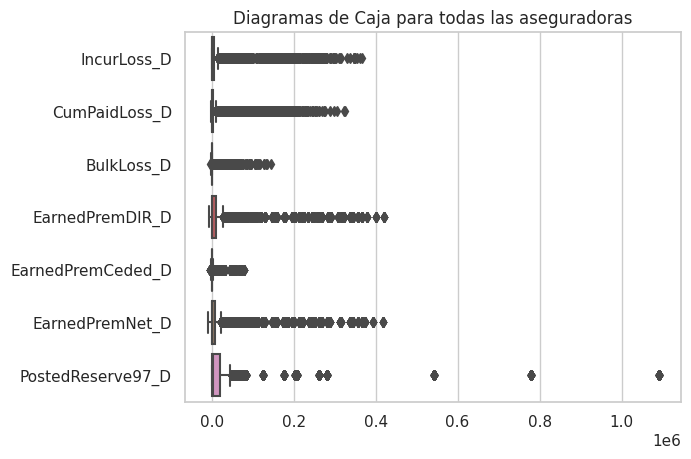

In [21]:
# Boxplots de las variables númericas
sns.set(style="whitegrid")  # Estilo del gráfico
# se filtraron los datos por las columnas de reservas, pérdidas y primas
data_box = data.drop(columns=['GRCODE', 'AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single'])
sns.boxplot(data=data_box, orient="h") # Boxplots
plt.title("Diagramas de Caja para todas las aseguradoras")
plt.show()

De las anteriores estadísticas descriptivas y los gráficos de boxplot podemos concluir que los datos de las reservas se encuentran bastante dispersos, lo cual se justifica debido a la discrepancia de tamaño entre las aseguradoras.

In [22]:
# Aseguradoras con reservas superiores a los $100 mil dólares
data.loc[data['PostedReserve97_D']>100000,'GRNAME'].unique()

array(['Allstate Ins Co Grp', 'California Cas Grp', 'Federal Ins Co Grp',
       'State Farm Mut Grp', 'Erie Ins Exchange Grp',
       'Pennsylvania Natl Ins Grp', 'New Jersey Manufacturers Grp',
       'Lumbermens Underwriting Alliance', 'Beacon Mut Ins Co'],
      dtype=object)

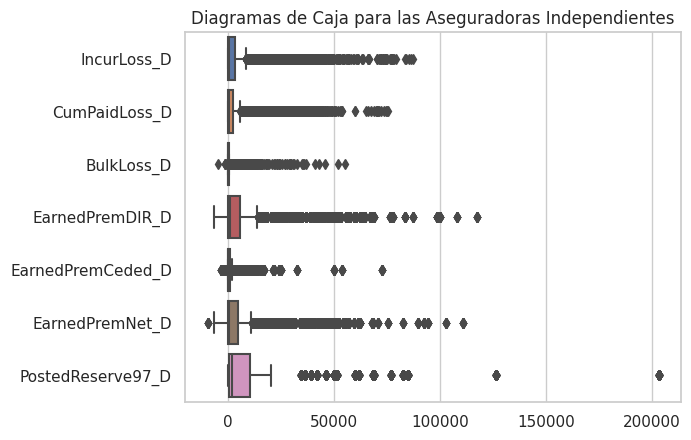

In [23]:
# Boxplots de las variables númericas en Aseguradoras Independientes
sns.set(style="whitegrid")  # Estilo del gráfico
# se filtraron los datos por las columnas de reservas, pérdidas y primas
data_box2 = data.loc[data['Single']==1,].drop(columns=['GRCODE', 'AccidentYear',
                                                       'DevelopmentYear','DevelopmentLag', 'Single'])
sns.boxplot(data=data_box2, orient="h") # Boxplots
plt.title("Diagramas de Caja para las Aseguradoras Independientes")
plt.show()

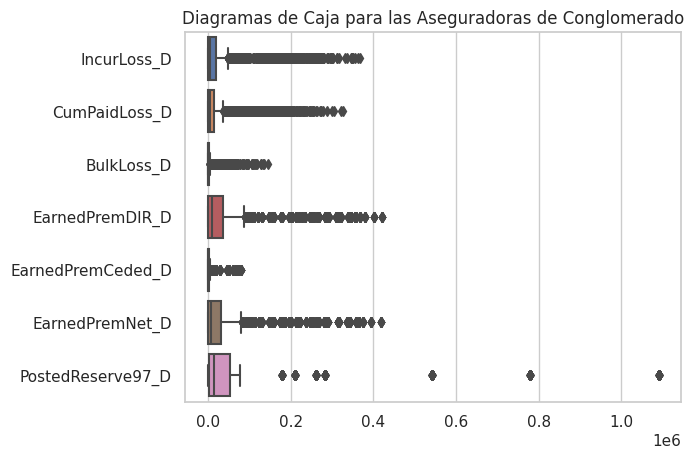

In [24]:
# Boxplots de las variables númericas en Aseguradoras de Conglomerado
sns.set(style="whitegrid")  # Estilo del gráfico
# se filtraron los datos por las columnas de reservas, pérdidas y primas
data_box3 = data.loc[data['Single']==0,].drop(columns=['GRCODE', 'AccidentYear',
                                                       'DevelopmentYear','DevelopmentLag', 'Single'])
sns.boxplot(data=data_box3, orient="h") # Boxplots
plt.title("Diagramas de Caja para las Aseguradoras de Conglomerado")
plt.show()

Realizando los gráficos diferenciando entre las aseguradoras independientes y las que son parte de un conglomerado se observa que las dispersión entre los datos de las variables disminuye significativamente.

In [25]:
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

Text(0.5, 1.0, 'Boxplot CumPaidLoss_D')

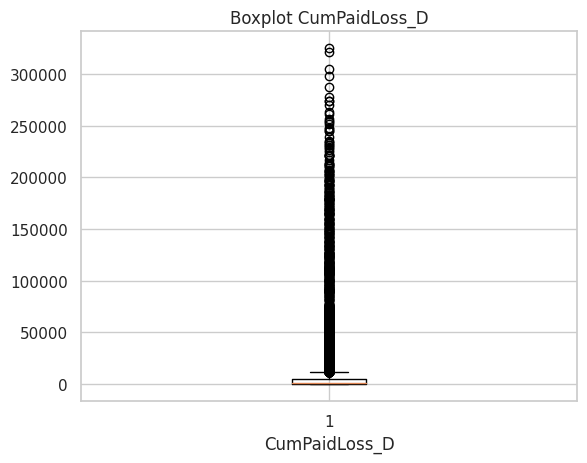

In [26]:
# Boxplot por variable
name_column = 'CumPaidLoss_D' # nombre de la columna
plt.boxplot(data[name_column], vert=True)
plt.xlabel(name_column)
#plt.ylabel('Valores')
plt.title(f'Boxplot {name_column}')

#### 2.3.3. Histogramas
Visualizaciones que ayuden a identificar patrones y relaciones.

In [27]:
data_box.columns

Index(['GRNAME', 'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D',
       'EarnedPremDIR_D', 'EarnedPremCeded_D', 'EarnedPremNet_D',
       'PostedReserve97_D'],
      dtype='object')

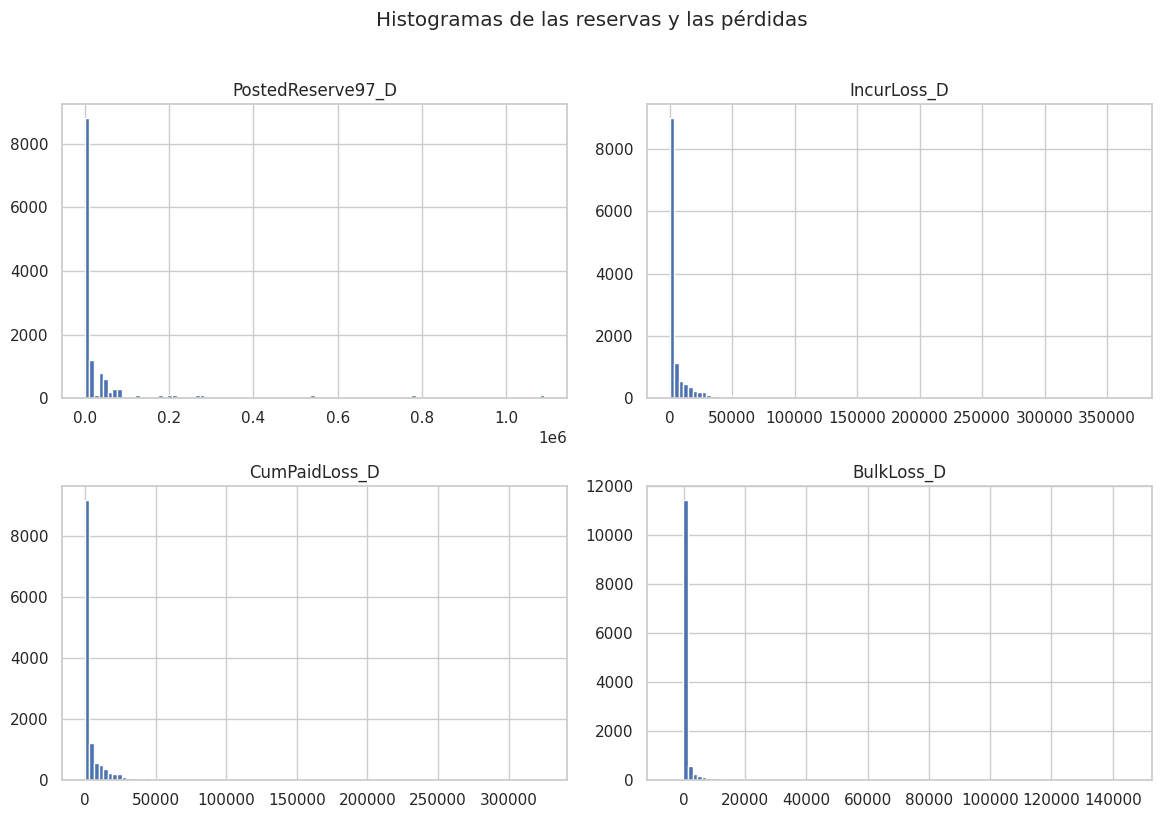

In [28]:
data_box[['PostedReserve97_D','IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D']].hist(figsize=(12, 8), bins=100)
plt.suptitle("Histogramas de las reservas y las pérdidas", y=1.02)
plt.tight_layout()
plt.show()

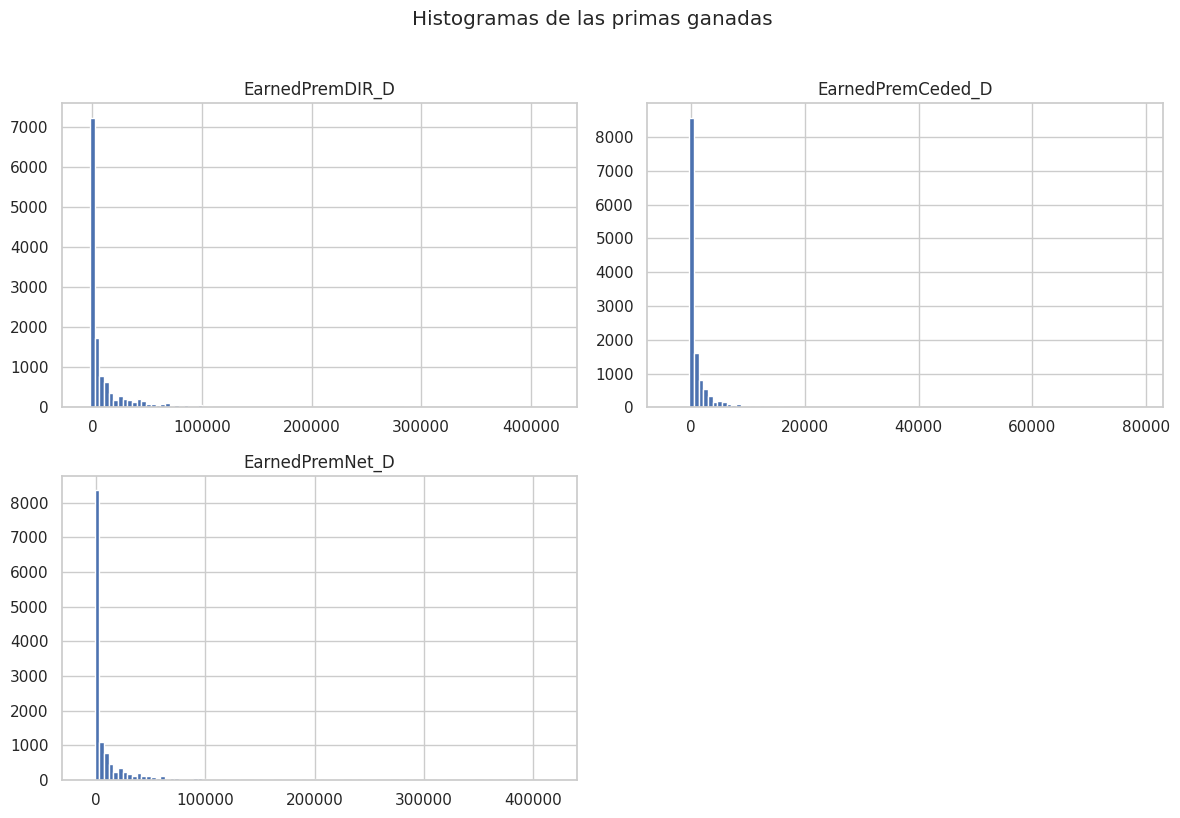

In [29]:
data_box[['EarnedPremDIR_D', 'EarnedPremCeded_D', 'EarnedPremNet_D']].hist(figsize=(12, 8), bins=100)
plt.suptitle("Histogramas de las primas ganadas", y=1.02)
plt.tight_layout()
plt.show()

In [30]:
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

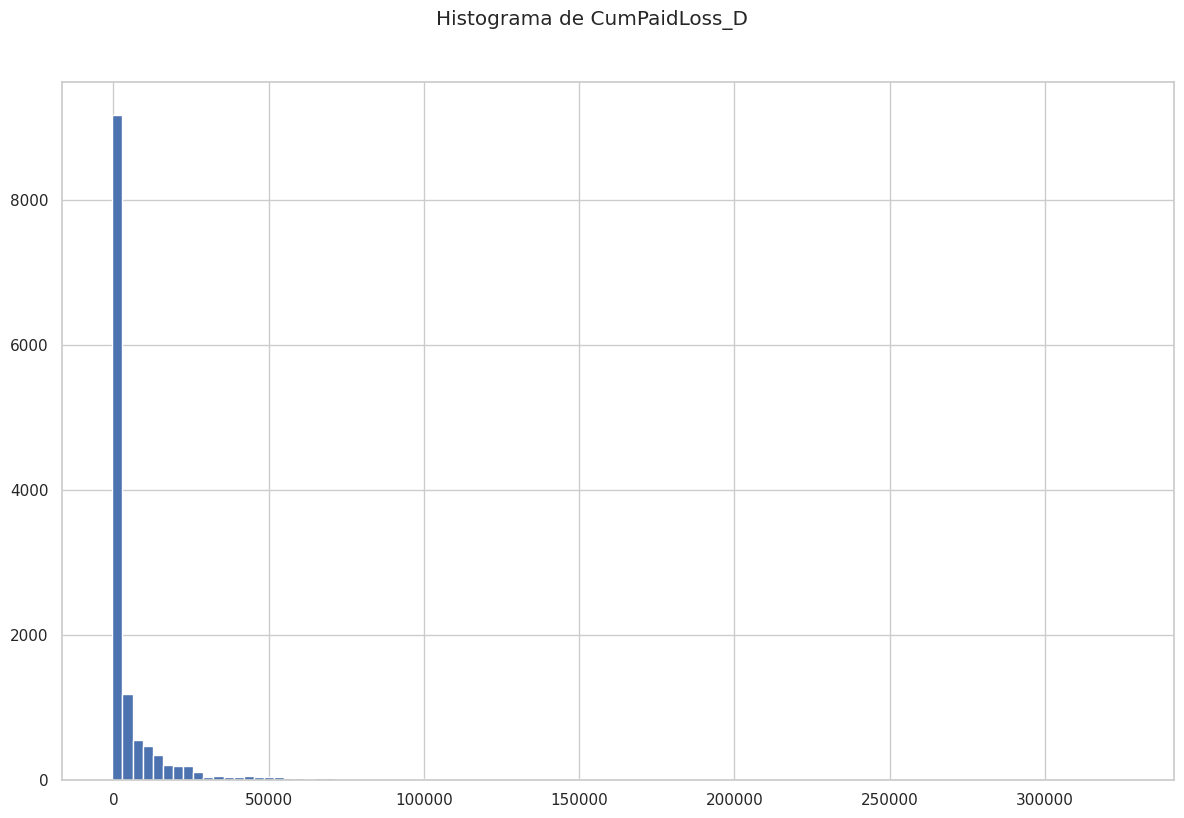

In [31]:
# Histograma por columna
name_column = 'CumPaidLoss_D'
data_box[name_column].hist(figsize=(12, 8), bins=100)
plt.suptitle(f'Histograma de {name_column}', y=1.02)
plt.tight_layout()
plt.show()

De estos gráficos podemos decir que todas las variables tienen una distribución sesgada a la derecha, por lo que para su modelamiento se pueden suponer distribuciones de probabilidad como la Pareto, Lognormal, Gamma o Weibull.  

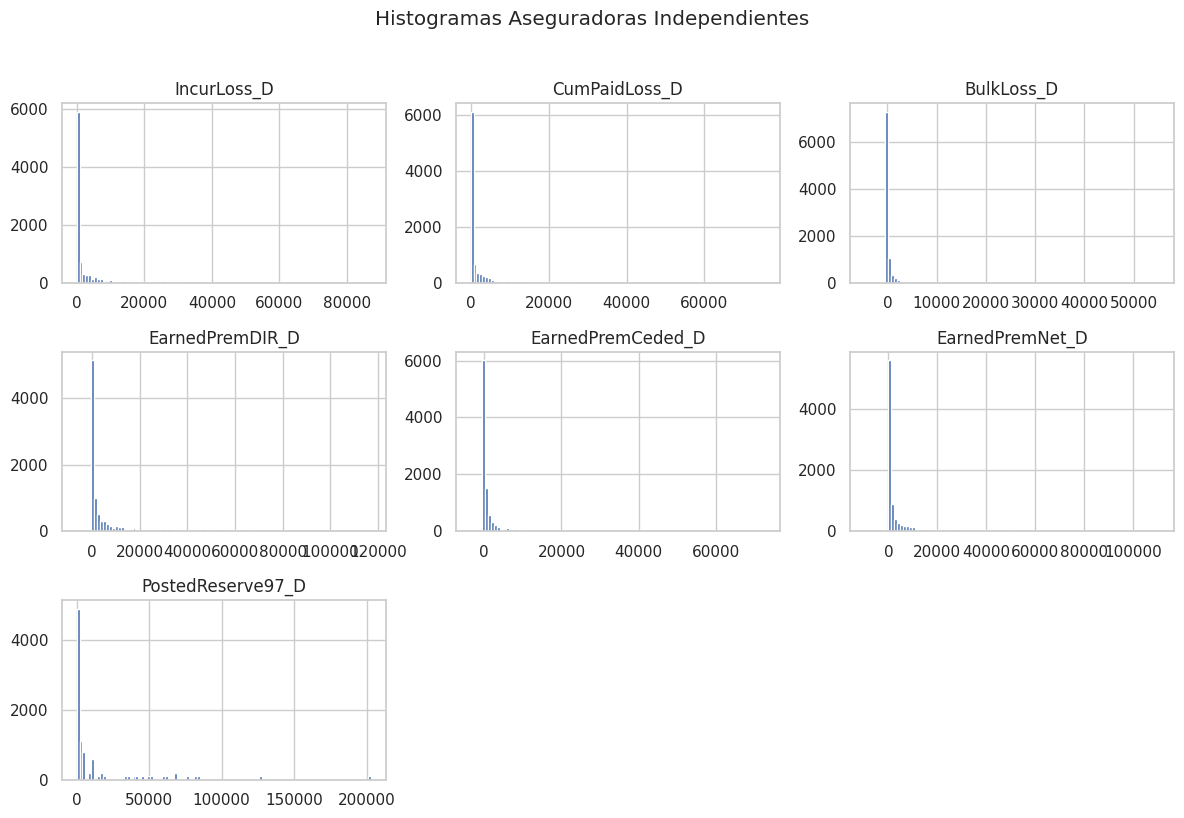

In [32]:
data_box2.hist(figsize=(12, 8), bins=100)
plt.suptitle("Histogramas Aseguradoras Independientes", y=1.02)
plt.tight_layout()
plt.show()

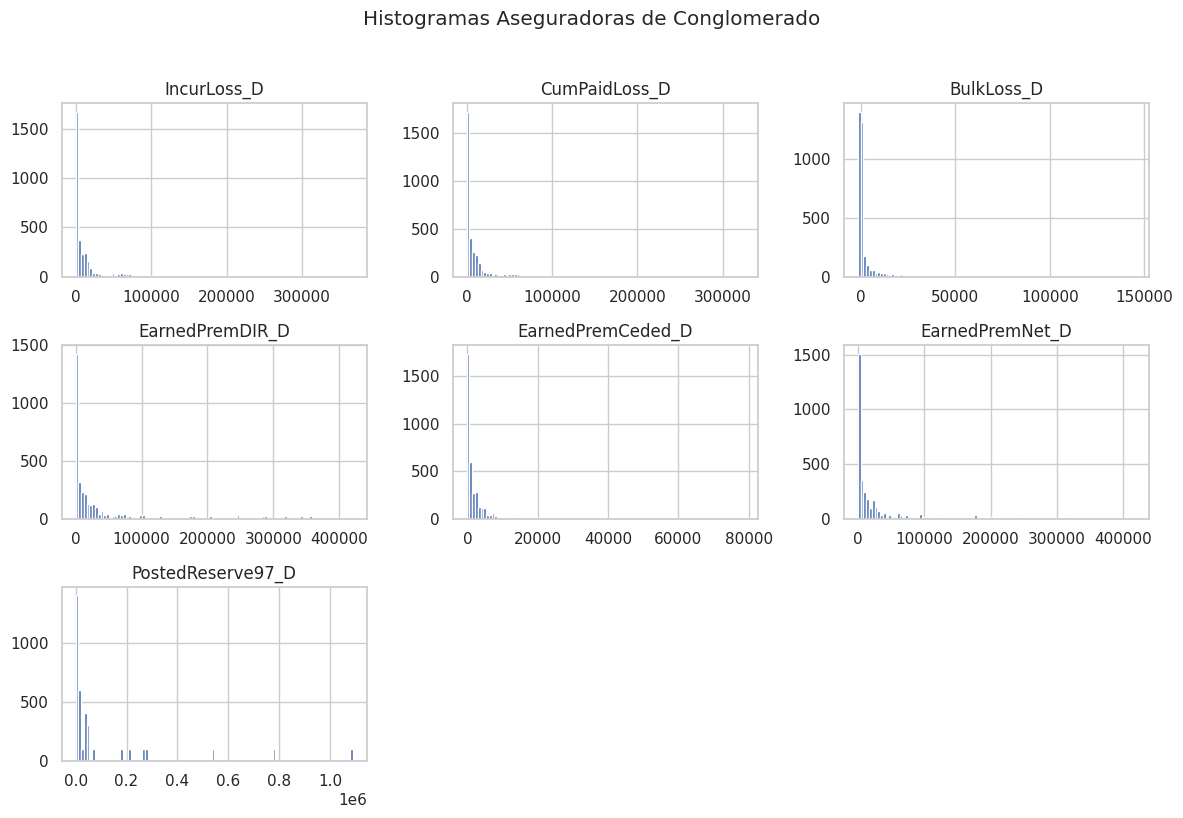

In [33]:
data_box3.hist(figsize=(12, 8), bins=100)
plt.suptitle("Histogramas Aseguradoras de Conglomerado", y=1.02)
plt.tight_layout()
plt.show()

#### 2.3.4. Correlaciones entre las variables
Se analizan las relaciones entre diferentes variables para identificar posibles correlaciones o dependencias.

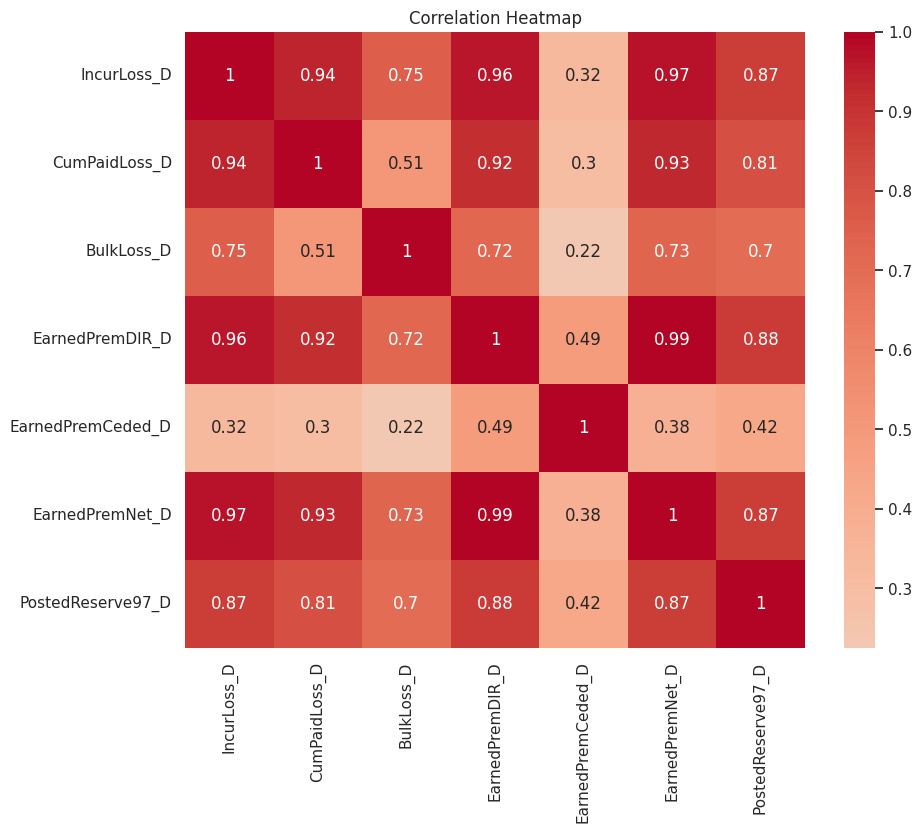

In [34]:
# Calculation of the correlation matrix
correlation_matrix = data_box.corr()
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

De estos datos podemos concluir que hay una fuerte relación lineal entre las variables '*IncurLoss_D*', 'CumPaidLoss_D', 'EarnedPremDIR_D', 'EarnedPremNet_D' y 'PostedReserve97_D'. Es decir, hay una fuerte dependencia entre las Pérdidas incurridas, las pérdidas acumuladas pagadas, las primas gaandas y las reservas de las aseguradoras.

### 2.4. Verificar la calidad de los datos
Se evalúa la calidad de los datos en términos de integridad, consistencia y posibles problemas como valores faltantes o datos incorrectos.

#### 2.4.1. Valores faltantes

In [35]:
# Validar si hay algun valor nulo o vacio en el data frame
nulos = data.isnull().any().sum()
print(f'Hay un total de {nulos} valores vacíos o nulos en la base de datos')

Hay un total de 0 valores vacíos o nulos en la base de datos


Por otro lado, de acuerdo a los gráficos anteriores observamos que hay una dispersión grande en los datos de todas las variables, distribuidos de forma asimétrica a la derecha, lo cual es justificado y tiene relación por la concentración de reclamaciones pequeñas y menos frecuentes reclamaciones grandes. Esto es común en seguros, donde un pequeño número de reclamaciones grandes puede tener un impacto significativo en las reservas.

### 2.5. Exploración de las estructuras de datos para el análisis (triángulos de run-off o de desarrollo)

Para el cálculo de reservas de siniestros en la industria de seguros una de las metodologías más usadas es el triángulo de desarollo. Un triángulo de desarrollo es una tabla que muestra cambios en el valor de varias cohortes de siniestros a través del tiempo (Fasecolda, 2022).

Para los ejemplos y el análisis desarrollado en está sección se trabajará con la variable **CumPaidLoss_D**, que como ya se había mencionado anteriormente corresponde a las pérdidas acumuladas pagadas y gastos asignados al final del año; lo cual representa la suma total de los pagos realizados por la aseguradora hasta ese momento para cubrir las reclamaciones y los costos asociados, incluyendo pagos realizados hasta el momento presente.

In [36]:
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

In [37]:
# Selected variable for analysis
variable = 'CumPaidLoss_D'

#### 2.5.1. Estadísticas descriptivas para la industria aseguradora

In [38]:
# Summary info 'CumPaidLoss_D' for insurer companies
data_sum = data.groupby(['AccidentYear','DevelopmentLag'])[['IncurLoss_D', 'CumPaidLoss_D', 'EarnedPremNet_D', 'BulkLoss_D']].sum().reset_index()

# Run-off triangle cummulative
pivot_data_sum = pd.pivot_table(data_sum, values=variable, index=['AccidentYear'], columns='DevelopmentLag', aggfunc=np.sum, fill_value=0)
pivot_data_sum

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,285804,638532,865100,996363,1084351,1133188,1169749,1196917,1229203,1241715
1989,307720,684140,916996,1065674,1154072,1210479,1249886,1291512,1308706,1324671
1990,320124,757479,1017144,1169014,1258975,1315368,1368374,1394675,1417384,1431483
1991,347417,793749,1053414,1209556,1307164,1381645,1414747,1447121,1465508,1479177
1992,342982,781402,1014982,1172915,1281864,1328801,1370935,1399901,1419809,1437891
1993,342385,743433,959147,1113314,1187581,1243689,1278194,1301968,1322101,1337171
1994,351060,750392,993751,1114842,1193861,1243285,1276145,1302620,1321778,1340950
1995,343841,768575,962081,1087925,1164217,1210269,1243983,1264903,1282868,1300678
1996,381484,736040,937936,1056949,1131168,1182716,1218813,1239839,1260284,1274282


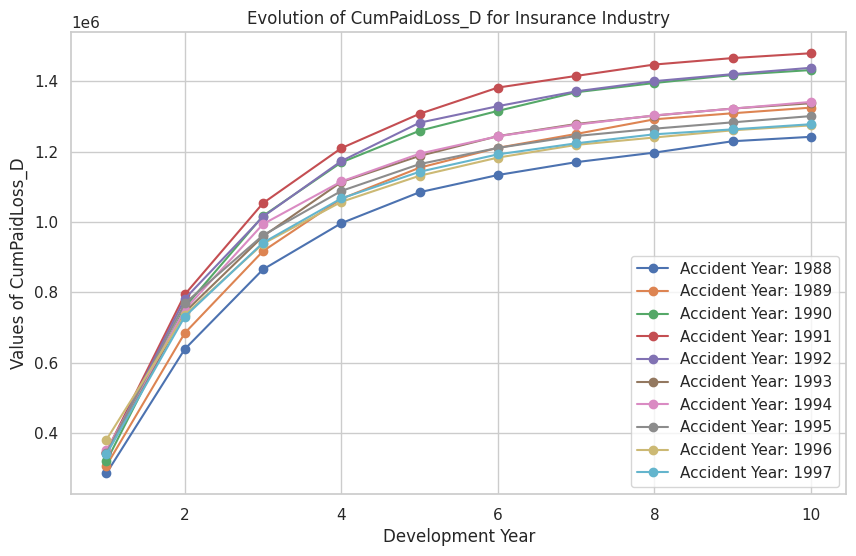

In [39]:
# Evolution of claims payment for insurance industry
plt.figure(figsize=(10, 6))
for year in pivot_data_sum.index:
    plt.plot(pivot_data_sum.columns, pivot_data_sum.loc[year], marker='o', linestyle='-',label=f'Accident Year: {year}')

plt.title(f'Evolution of {variable} for Insurance Industry')
plt.xlabel('Development Year')
plt.ylabel(f'Values of {variable}')
plt.legend()
plt.grid(True)
plt.show()

#### 2.5.2. Estadísticas descriptivas - triángulos de desarrollo por aseguradora



In [40]:
codes = data['GRCODE'].unique() # insurer codes
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

Triángulos de desarrollo completos

In [41]:
triangles = triangles_function(data,codes,'CumPaidLoss_D')

Triangulos de desarrollo parte superior

In [42]:
triangles_upper = triangles_upper_function(triangles)

Triangulos de desarrollo parte inferior

In [43]:
triangles_lower = triangles_lower_function(triangles)

In [44]:
triangles[86] # run-off triangle

DevelopmentLag          1       2       3       4       5       6       7   \
GRCODE AccidentYear                                                          
86     1988          70571  155905  220744  251595  274156  287676  298499   
       1989          66547  136447  179142  211343  231430  244750  254557   
       1990          52233  133370  178444  204442  222193  232940  253337   
       1991          59315  128051  169793  196685  213165  234676  239195   
       1992          39991   89873  114117  133003  154362  159496  164013   
       1993          19744   47229   61909   85099   87215   88602   89444   
       1994          20379   46773   88636   91077   92583   93346   93897   
       1995          18756   84712   87311   89200   90001   90247   90687   
       1996          42609   44916   46981   47899   48583   49109   49442   
       1997            691    2085    2795    2866    2905    2909    2908   

DevelopmentLag           8       9       10  
GRCODE AccidentYear                          
86     1988          304873  321808  325322  
       1989          270059  273873  277574  
       1990          256788  261166  263000  
       1991          245499  247131  248319  
       1992          166212  167397  168844  
       1993           89899   90446   90686  
       1994           94165   94558   94730  
       1995           91068   91001   91161  
       1996           49073   49161   49255  
       1997            2909    2909    2909

In [45]:
triangles_lower[86] # example for a company

DevelopmentLag       1       2        3        4        5        6         7   \
GRCODE AccidentYear                                                             
86     1988         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1989         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1990         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1991         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1992         NaN     NaN      NaN      NaN      NaN      NaN  164013.0   
       1993         NaN     NaN      NaN      NaN      NaN  88602.0   89444.0   
       1994         NaN     NaN      NaN      NaN  92583.0  93346.0   93897.0   
       1995         NaN     NaN      NaN  89200.0  90001.0  90247.0   90687.0   
       1996         NaN     NaN  46981.0  47899.0  48583.0  49109.0   49442.0   
       1997         NaN  2085.0   2795.0   2866.0   2905.0   2909.0    2908.0   

DevelopmentLag             8         9         10  
GRCODE AccidentYear                                
86     1988               NaN       NaN       NaN  
       1989               NaN       NaN  277574.0  
       1990               NaN  261166.0  263000.0  
       1991          245499.0  247131.0  248319.0  
       1992          166212.0  167397.0  168844.0  
       1993           89899.0   90446.0   90686.0  
       1994           94165.0   94558.0   94730.0  
       1995           91068.0   91001.0   91161.0  
       1996           49073.0   49161.0   49255.0  
       1997            2909.0    2909.0    2909.0

In [46]:
triangles_upper[86] # example for a company

DevelopmentLag          1         2         3         4         5         6   \
GRCODE AccidentYear                                                            
86     1988          70571  155905.0  220744.0  251595.0  274156.0  287676.0   
       1989          66547  136447.0  179142.0  211343.0  231430.0  244750.0   
       1990          52233  133370.0  178444.0  204442.0  222193.0  232940.0   
       1991          59315  128051.0  169793.0  196685.0  213165.0  234676.0   
       1992          39991   89873.0  114117.0  133003.0  154362.0  159496.0   
       1993          19744   47229.0   61909.0   85099.0   87215.0       NaN   
       1994          20379   46773.0   88636.0   91077.0       NaN       NaN   
       1995          18756   84712.0   87311.0       NaN       NaN       NaN   
       1996          42609   44916.0       NaN       NaN       NaN       NaN   
       1997            691       NaN       NaN       NaN       NaN       NaN   

DevelopmentLag             7         8         9         10  
GRCODE AccidentYear                                          
86     1988          298499.0  304873.0  321808.0  325322.0  
       1989          254557.0  270059.0  273873.0       NaN  
       1990          253337.0  256788.0       NaN       NaN  
       1991          239195.0       NaN       NaN       NaN  
       1992               NaN       NaN       NaN       NaN  
       1993               NaN       NaN       NaN       NaN  
       1994               NaN       NaN       NaN       NaN  
       1995               NaN       NaN       NaN       NaN  
       1996               NaN       NaN       NaN       NaN  
       1997               NaN       NaN       NaN       NaN

In [47]:
df = pd.DataFrame(triangles[86])
df.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64', name='DevelopmentLag')

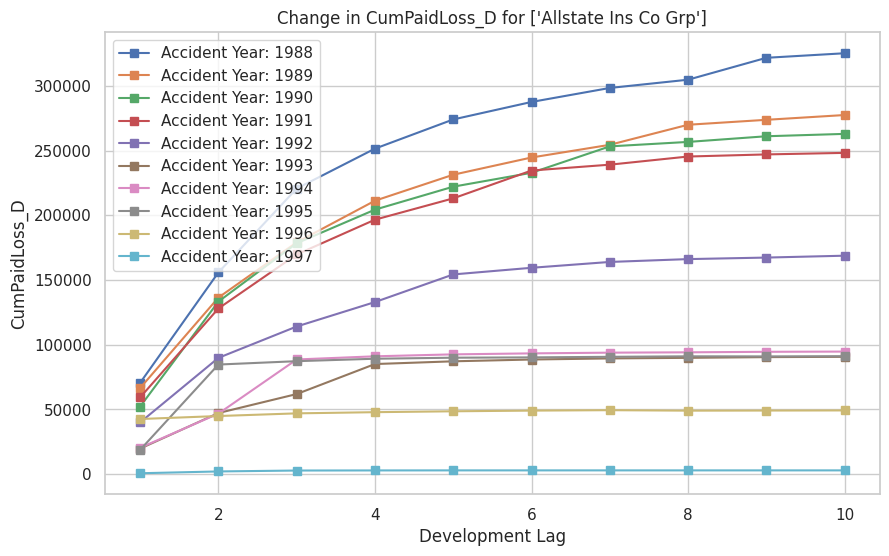

In [48]:
code = 86 # insurance company code
name_company = data.loc[(data['GRCODE']==code),'GRNAME'].unique().astype(str)
years = [1988,1989,1990,1991,1992,1993,1994,1995,1996,1997] # year specific
plt.figure(figsize=(10, 6))
for year in years:
    triangle_year = triangles[code].xs(year, level=1)
    codes_insur = triangle_year.index.get_level_values(0).unique()
    datos_aseguradora = triangle_year.loc[code]
    years_later = datos_aseguradora.index.tolist()
    pagos_reclamaciones = datos_aseguradora.tolist()
    plt.plot(years_later, pagos_reclamaciones, marker='s', linestyle='-', label=f'Accident Year: {year}')

plt.title(f'Change in {variable} for {name_company}')
plt.xlabel('Development Lag')
plt.ylabel(f'{variable}')
plt.legend()
plt.grid(True)

# show plot
plt.show()

## 3) Preparación de los datos

### 3.1. Seleccionar los datos
Se quiere realizar un modelo de predicción de las reservas que debería tener una aseguradora de la línea de seguros de compensación laboral, siguiendo la metodología de Chain Ladder con triángulos de desarrollo con aprendizaje de maquinas para predecir el monto de las reclamaciones futuras. Para este propósito se trabajará con las  siguientes variables del conjunto de datos:
+ Línea de negocio (*'Single'*): Indica si se trata de una entidad única (1) o una aseguradora de grupo (0). Esto puede ser relevante para considerar la estructura de la empresa aseguradora.
+ Código de empresa(*'GRCODE'*)
+ Año del accidente (*'AccidentYear'*): El año en que ocurrió el evento o accidente que dio lugar a la reclamación.
+ Retraso en el desarrollo (*'DevelopmentLag'*): Representa cuántos años han pasado desde el año de ocurrencia del evento hasta el año actual. Esta variable es fundamental para construir los triángulos de desarrollo.
+ Pérdida incurrida (*'IncurLoss_D'*): Pérdidas incurridas y gastos asignados reportados al final del año. Esta cifra es una parte importante en la evaluación de la cantidad total de dinero que la aseguradora espera gastar para cubrir las reclamaciones y los costos asociados en ese año específico.
+ Pérdida pagada acumulada (*'CumPaidLoss_D'*): El monto acumulado pagado en reclamaciones hasta el año de desarrollo correspondiente. Este es un valor crítico para calcular las reservas.
+ IBNR (*'BulkLoss'*): Las reservas a granel y los gastos de defensa y costos de contención reportados al final del año. Esto puede ser relevante para tener en cuenta costos adicionales asociados a las reclamaciones.
+ Prima neta ganada (*'EarnedPremNet_D'*): Las primas devengadas en el año de ocurrencia del evento. Lo cual se utilizará para calcular las tasas de siniestralidad y es relevante para determinar la relación entre las pérdidas y las primas.
+ Reservas publicadas (*'PostedReserve97_D'*): Las reservas publicadas en un año específico. Esto puede utilizarse como referencia para comparar con las estimaciones del modelo.

In [49]:
#data.groupby(['AccidentYear','DevelopmentLag'])[['IncurLoss_D','CumPaidLoss_D',
#                                                 'BulkLoss_D','EarnedPremNet_D',
#                                                 'PostedReserve97_D']].sum().reset_index().describe().drop(columns=['AccidentYear','DevelopmentLag'])
data[['IncurLoss_D','CumPaidLoss_D','BulkLoss_D','EarnedPremNet_D','PostedReserve97_D']].describe()

,IncurLoss_D,CumPaidLoss_D,BulkLoss_D,EarnedPremNet_D,PostedReserve97_D
count,13200.000000,13200.000000,13200.000000,13200.000000,1.320000e+04
mean,11532.048258,8215.737348,1570.125606,16626.128788,3.971440e+04
std,35595.560208,25714.081464,7259.022141,48941.724122,1.301307e+05
min,-59.000000,-338.000000,-4621.000000,-9731.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,4.110000e+02
50%,544.000000,351.500000,5.000000,827.000000,2.732000e+03
75%,6526.500000,4565.000000,259.250000,9180.500000,1.926575e+04
max,367404.000000,325322.000000,145296.000000,418755.000000,1.090093e+06


In [50]:
# Data selection for model training
type_company = 1 # 1 for single y 0 groups
subset = data[data['Single']==type_company]
variables = ['GRCODE', 'AccidentYear', 'DevelopmentLag', 'IncurLoss_D',
             'CumPaidLoss_D', 'BulkLoss_D','EarnedPremNet_D', 'PostedReserve97_D']
subset = subset[variables]
subset.head(10)

,GRCODE,AccidentYear,DevelopmentLag,IncurLoss_D,CumPaidLoss_D,BulkLoss_D,EarnedPremNet_D,PostedReserve97_D
3600,10011,1988,1,0,0,0,0,8967
3601,10011,1988,2,0,0,0,0,8967
3602,10011,1988,3,0,0,0,0,8967
3603,10011,1988,4,0,0,0,0,8967
3604,10011,1988,5,0,0,0,0,8967
3605,10011,1988,6,0,0,0,0,8967
3606,10011,1988,7,0,0,0,0,8967
3607,10011,1988,8,0,0,0,0,8967
3608,10011,1988,9,0,0,0,0,8967
3609,10011,1988,10,0,0,0,0,8967


### 3.2. Construir los datos
Las reclamaciones pendientes, a los efectos de este modelo, se derivan de la pérdida incurrida menos la pérdida pagada acumulada. El código de empresa es una variable categórica que indica a qué aseguradora están asociados los registros.

In [51]:
variables = ['IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremNet_D']
variable = variables[1]
print(f'La variable seleccionada para el modelo es "{variable}"')

La variable seleccionada para el modelo es "CumPaidLoss_D"


In [52]:
# A dictionary created with the run-off triangles of the insurers
# run-off triangles complete
codes = data['GRCODE'].unique() # insurer codes
triangles = triangles_function(data, codes)

Para algunas aseguradoras se tienen ceros en algunos años de desarrollo. Para evitar errores en el modelo y para el caso de aplicación del modelo de chain ladder determinístico se quitaran estas aseguradoras.

In [53]:
triangles_filtered = triangles_filtered_function(triangles)
len(triangles_filtered)

59

In [54]:
print(f'Sacando las aseguradoras que tienen algunos años en ceros quedamos con un total de {len(triangles_filtered)}  aseguradoras para el análisis.')

Sacando las aseguradoras que tienen algunos años en ceros quedamos con un total de 59  aseguradoras para el análisis.


In [55]:
codes = list(triangles_filtered.keys())

In [56]:
# Upper triangles
triangles_upper_filtered = triangles_upper_function(triangles_filtered)
len(triangles_upper_filtered)

59

In [57]:
triangles_upper_filtered[86] # example for a company

DevelopmentLag          1         2         3         4         5         6   \
GRCODE AccidentYear                                                            
86     1988          70571  155905.0  220744.0  251595.0  274156.0  287676.0   
       1989          66547  136447.0  179142.0  211343.0  231430.0  244750.0   
       1990          52233  133370.0  178444.0  204442.0  222193.0  232940.0   
       1991          59315  128051.0  169793.0  196685.0  213165.0  234676.0   
       1992          39991   89873.0  114117.0  133003.0  154362.0  159496.0   
       1993          19744   47229.0   61909.0   85099.0   87215.0       NaN   
       1994          20379   46773.0   88636.0   91077.0       NaN       NaN   
       1995          18756   84712.0   87311.0       NaN       NaN       NaN   
       1996          42609   44916.0       NaN       NaN       NaN       NaN   
       1997            691       NaN       NaN       NaN       NaN       NaN   

DevelopmentLag             7         8         9         10  
GRCODE AccidentYear                                          
86     1988          298499.0  304873.0  321808.0  325322.0  
       1989          254557.0  270059.0  273873.0       NaN  
       1990          253337.0  256788.0       NaN       NaN  
       1991          239195.0       NaN       NaN       NaN  
       1992               NaN       NaN       NaN       NaN  
       1993               NaN       NaN       NaN       NaN  
       1994               NaN       NaN       NaN       NaN  
       1995               NaN       NaN       NaN       NaN  
       1996               NaN       NaN       NaN       NaN  
       1997               NaN       NaN       NaN       NaN

### 3.3. Partición de los datos


## 4) Modelación

{Responder las preguntas dde la presentación (foto celular)}

### 4.1. Chain ladder determinístico




In [58]:
predict_triangles = chain_ladder_deterministico(triangles_upper_filtered)

In [59]:
print('Tamaño de la muestra para el experimento Chain Ladder Determinístico:')
print(f'>>> {len(triangles_upper_filtered)} aseguradoras')

Tamaño de la muestra para el experimento Chain Ladder Determinístico:
>>> 59 aseguradoras


In [60]:
triangles_filtered[86]

DevelopmentLag          1       2       3       4       5       6       7   \
GRCODE AccidentYear                                                          
86     1988          70571  155905  220744  251595  274156  287676  298499   
       1989          66547  136447  179142  211343  231430  244750  254557   
       1990          52233  133370  178444  204442  222193  232940  253337   
       1991          59315  128051  169793  196685  213165  234676  239195   
       1992          39991   89873  114117  133003  154362  159496  164013   
       1993          19744   47229   61909   85099   87215   88602   89444   
       1994          20379   46773   88636   91077   92583   93346   93897   
       1995          18756   84712   87311   89200   90001   90247   90687   
       1996          42609   44916   46981   47899   48583   49109   49442   
       1997            691    2085    2795    2866    2905    2909    2908   

DevelopmentLag           8       9       10  
GRCODE AccidentYear                          
86     1988          304873  321808  325322  
       1989          270059  273873  277574  
       1990          256788  261166  263000  
       1991          245499  247131  248319  
       1992          166212  167397  168844  
       1993           89899   90446   90686  
       1994           94165   94558   94730  
       1995           91068   91001   91161  
       1996           49073   49161   49255  
       1997            2909    2909    2909

In [61]:
predict_triangles[86]

DevelopmentLag          1              2              3              4   \
GRCODE AccidentYear                                                       
86     1988          70571  155905.000000  220744.000000  251595.000000   
       1989          66547  136447.000000  179142.000000  211343.000000   
       1990          52233  133370.000000  178444.000000  204442.000000   
       1991          59315  128051.000000  169793.000000  196685.000000   
       1992          39991   89873.000000  114117.000000  133003.000000   
       1993          19744   47229.000000   61909.000000   85099.000000   
       1994          20379   46773.000000   88636.000000   91077.000000   
       1995          18756   84712.000000   87311.000000  101143.981086   
       1996          42609   44916.000000   60085.500190   69605.051995   
       1997            691    1536.064068    2054.839654    2380.394945   

DevelopmentLag                  5              6              7   \
GRCODE AccidentYear                                                
86     1988          274156.000000  287676.000000  298499.000000   
       1989          231430.000000  244750.000000  254557.000000   
       1990          222193.000000  232940.000000  253337.000000   
       1991          213165.000000  234676.000000  239195.000000   
       1992          154362.000000  159496.000000  166760.099724   
       1993           87215.000000   92329.546875   96534.611805   
       1994           99522.961906  105359.284257  110157.776681   
       1995          110523.497443  117004.923901  122333.806352   
       1996           76059.827818   80520.202234   84187.421342   
       1997            2601.139206    2753.677742    2879.091481   

DevelopmentLag                  8              9              10  
GRCODE AccidentYear                                               
86     1988          304873.000000  321808.000000  325322.000000  
       1989          270059.000000  273873.000000  276863.571154  
       1990          256788.000000  266055.346768  268960.552632  
       1991          246707.579803  255611.129394  258402.289056  
       1992          171997.661366  178204.968449  180150.887317  
       1993           99566.547986  103159.853463  104286.313106  
       1994          113617.585993  117717.986200  119003.414168  
       1995          126176.037514  130729.665773  132157.175486  
       1996           86831.559895   89965.266205   90947.646834  
       1997            2969.517303    3076.685654    3110.281691

In [62]:
# Lower triangles original
triangles_lower_original = triangles_lower_function(triangles_filtered)
# predicted triangles
triangles_lower_predicted = triangles_lower_function(predict_triangles)

In [63]:
# Example of lower triangle with original data
triangles_lower_original[86]

DevelopmentLag       1       2        3        4        5        6         7   \
GRCODE AccidentYear                                                             
86     1988         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1989         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1990         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1991         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1992         NaN     NaN      NaN      NaN      NaN      NaN  164013.0   
       1993         NaN     NaN      NaN      NaN      NaN  88602.0   89444.0   
       1994         NaN     NaN      NaN      NaN  92583.0  93346.0   93897.0   
       1995         NaN     NaN      NaN  89200.0  90001.0  90247.0   90687.0   
       1996         NaN     NaN  46981.0  47899.0  48583.0  49109.0   49442.0   
       1997         NaN  2085.0   2795.0   2866.0   2905.0   2909.0    2908.0   

DevelopmentLag             8         9         10  
GRCODE AccidentYear                                
86     1988               NaN       NaN       NaN  
       1989               NaN       NaN  277574.0  
       1990               NaN  261166.0  263000.0  
       1991          245499.0  247131.0  248319.0  
       1992          166212.0  167397.0  168844.0  
       1993           89899.0   90446.0   90686.0  
       1994           94165.0   94558.0   94730.0  
       1995           91068.0   91001.0   91161.0  
       1996           49073.0   49161.0   49255.0  
       1997            2909.0    2909.0    2909.0

In [64]:
# Example of lower triangle with predicted data
triangles_lower_predicted[86]

DevelopmentLag       1            2             3              4   \
GRCODE AccidentYear                                                 
86     1988         NaN          NaN           NaN            NaN   
       1989         NaN          NaN           NaN            NaN   
       1990         NaN          NaN           NaN            NaN   
       1991         NaN          NaN           NaN            NaN   
       1992         NaN          NaN           NaN            NaN   
       1993         NaN          NaN           NaN            NaN   
       1994         NaN          NaN           NaN            NaN   
       1995         NaN          NaN           NaN  101143.981086   
       1996         NaN          NaN  60085.500190   69605.051995   
       1997         NaN  1536.064068   2054.839654    2380.394945   

DevelopmentLag                  5              6              7   \
GRCODE AccidentYear                                                
86     1988                    NaN            NaN            NaN   
       1989                    NaN            NaN            NaN   
       1990                    NaN            NaN            NaN   
       1991                    NaN            NaN            NaN   
       1992                    NaN            NaN  166760.099724   
       1993                    NaN   92329.546875   96534.611805   
       1994           99522.961906  105359.284257  110157.776681   
       1995          110523.497443  117004.923901  122333.806352   
       1996           76059.827818   80520.202234   84187.421342   
       1997            2601.139206    2753.677742    2879.091481   

DevelopmentLag                  8              9              10  
GRCODE AccidentYear                                               
86     1988                    NaN            NaN            NaN  
       1989                    NaN            NaN  276863.571154  
       1990                    NaN  266055.346768  268960.552632  
       1991          246707.579803  255611.129394  258402.289056  
       1992          171997.661366  178204.968449  180150.887317  
       1993           99566.547986  103159.853463  104286.313106  
       1994          113617.585993  117717.986200  119003.414168  
       1995          126176.037514  130729.665773  132157.175486  
       1996           86831.559895   89965.266205   90947.646834  
       1997            2969.517303    3076.685654    3110.281691

### 4.2. Métrica de desempeño
Se utilizaran las siguientes medidas de desempeño para evaluar el modelo sobre la industria aseguradora. Se proponen dos enfoques para este análisis: uno, las métricas de desempeño de cada aseguradora y una métrica ponderada para el desempeño del modelo en toda la industria.

+ Error Cuadrático Medio (MSE - Mean Squared Error): El MSE mide el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales.

  Fórmula: $$ MSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

  Donde yi son los valores reales, ŷi son las predicciones del modelo, y n es el número de observaciones.

+ Porcentaje de Error Absoluto Promedio (MAPE - Mean Absolute Percentage Error): El MAPE mide la precisión de un modelo o un método de pronóstico al calcular el porcentaje promedio de error absoluto en relación con los valores reales. Esta métrica es útil para evaluar qué tan cerca están las predicciones del modelo de los valores reales en términos porcentuales.
  Fórmula: $$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \frac{|Y_i - \hat{Y}_i|}{|Y_i|} \times 100\% $$
  
  Donde yi son los valores reales, ŷi son las predicciones del modelo, y n es el número de observaciones.


In [65]:
performance_result_function('Chain Ladder Determinístico', triangles_lower_original, triangles_lower_predicted)

El Porcentaje de Error Absoluto Promedio del modelo Chain Ladder Determinístico es 10.67%.
 
La métricas de desempeño por aseguradora en el Experimento son las siguientes:
 
    Insurer Company           MSE       MAPE
0                86  17820.268351  20.091369
1               337   1732.970105   2.657980
2               353    229.750022  16.811936
3               388  10159.660787   8.432703
4               671    128.101517   1.257895
5               715    655.809240   1.550136
6               965    493.775333   8.297465
7              1066    979.019025  12.348233
8              1252    232.101013   9.301804
9              1538    645.749187   3.973560
10             1767   7114.896470   4.530459
11             2135   3265.887388   3.340898
12             2712   3051.096844   4.155391
13             3034    998.204166   5.828213
14             3240    336.502357   5.737267
15             5185    759.491884   3.679041
16             6408    403.107872   5.964832
17             6

### 4.3. Diseño del experimento - Modelo de Regresión
Modelo de machine learning

In [66]:
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

In [67]:
codes = codes_function(data, 'All')
triangles_rg = triangles_function(data, codes, 'IncurLoss_D')
print(triangles_rg[list(triangles_rg.keys())[0]])
triangles_rg = triangles_function(data, codes, 'CumPaidLoss_D')
print(triangles_rg[list(triangles_rg.keys())[0]])

DevelopmentLag           1       2       3       4       5       6       7   \
GRCODE AccidentYear                                                           
86     1988          367404  362988  347288  330648  354690  350092  346808   
       1989          336928  316483  278496  303033  299496  295061  299251   
       1990          289198  311381  277980  277732  276563  278067  276704   
       1991          297174  277209  269739  272666  271318  267578  269592   
       1992          181796  205079  199106  187833  185663  184940  184507   
       1993          114807  114774  101460   98430   96930   96121   98085   
       1994          107934  107569   97730   96185   96124   95821   95722   
       1995          100686   94456   92314   92241   92929   92214   92107   
       1996           53381   51205   51087   51015   50226   50343   50060   
       1997            6725    6663    6473    2917    2933    3103    3002   

DevelopmentLag           8       9       10  
GRCOD

In [68]:
codes = codes_function(data, 'All')
triangles_rg = triangles_filtered_function(triangles_function(data, codes, 'IncurLoss_D')) # run-off triangles complete
tr_up_rg = triangles_upper_function(triangles_rg) # upper triangles
print(f'Tamaño muestral: {len(triangles_rg)} aseguradoras')
# print(' ')
# print(tr_up_rg[list(tr_up_rg.keys())[0]]) # print first element

Tamaño muestral: 62 aseguradoras


In [69]:
def chain_ladder_linear(triangles_uppers):
  '''
  Function definition:
    This function return the predicted run-off triangle with chain
    ladder linear method.

  Input:
    triangles_uppers: "A Dictionary with upper run-off triangles."

  Output:
    A dictionary with predicted run-off triangles with Chain Ladder
    Linear Model.
  '''
  predict_triangles = {}
  codes = list(triangles_uppers.keys())
  for code in codes:
    predict_triangle = triangles_uppers[code]
    for row in range(predict_triangle.shape[0]):
      for column in range(predict_triangle.shape[1]):
        if np.isnan(predict_triangle.iloc[row, column]):
          dev_factor = predict_triangle.iloc[0:row, column].sum() / predict_triangle.iloc[0:row, column-1].sum()
          predict_triangle.iloc[row, column] = predict_triangle.iloc[row, column-1]*dev_factor

    predict_triangles[code] = predict_triangle

  return predict_triangles

## 5) Evaluación de modelo

# Bibliografía
#  https://ewfrees.github.io/Loss-Data-Analytics-Spanish/C-LossReserves.html


# Notas de clase
Para el 24 de Octubre se deben traer:
* Diseño Experimentar --> Leave one out cross validation (training, validation, test)  
* Modelo de Regresión
* Performance